# Variables

In [1]:
#Variables

notional = 1000
risk_free_rate = 0.036
annual_volatility_of_GSPC = 0.15
asset_correlation = 0
#day_count_convention = ACT/365
#random seed = 123 for Monte Carlo simulation

#Dates
import numpy as np
import datetime

T0 = datetime.date(2024,12,31)
Maturity = datetime.date(2026,2,15)
Observation_date1 = datetime.date(2025,6,2)
Observation_date2 = datetime.date(2025,12,2)

accrual_factors = []
T1 = round((Observation_date1 - T0).days/365,2)
T2 = round((Observation_date2 - T0).days/365,2)
T3 = round((Maturity - T0).days/365,2)
accrual_factors.append(T1)
accrual_factors.append(T2)
accrual_factors.append(T3)

#building the discounting curve
discounting_curve = []
for accrual_factor in accrual_factors:
    discounting_curve.append(np.exp(-risk_free_rate*accrual_factor))
#Underlyings

#S&P 500 Ticker : GSPC
#€STR modelled as one factor short rate process
S0 = 5881.63
r0 = 0.029

#Barriers

BS = 0.95*S0
Br = 0.95*r0

#short_rate_model_parameters

kappa = 0.5602
theta = 0.0432
#I made the assumption rate volatility was annual as well
annual_volatility_of_ESTR = 0.0092

Our valuation has multiple future dates influencing payoff, meaning a classic Black Scholes to estimate future price of the equity underlying doesn't fit. We need to use a path dependant method, so we use the Euler-Maruyama method. risk free rate is supposed constant. volatility is supposed constant. equity price is log normaly distributed.

In [2]:
#daily time step
import numpy as np

US_market_closed = [
    '2025-01-01', '2025-01-20', '2025-02-17', '2025-04-18',
    '2025-05-26', '2025-06-19', '2025-07-04', '2025-09-01',
    '2025-11-27', '2025-12-25', '2026-01-01', '2026-01-19'
]
time_steps = np.busday_count(T0, Maturity, holidays=US_market_closed)
#I will still need to know the actual dates for T1 and T2
#15 Feb 2026 is actually a sunday so we take 13 Feb 2026 instead as maturity
for i in range(time_steps):
    date_i = np.busday_offset(T0, i, roll='forward', holidays=US_market_closed)
    if date_i == np.datetime64('2025-06-02') or date_i == np.datetime64('2025-12-02') or date_i == np.datetime64('2026-02-13'):
        print(f"{date_i} : {i}")
#Finally the Monte Carlo Simulation
delta_t = T3 / time_steps
np.random.seed(123)
Z = np.random.standard_normal((100_000, time_steps + 1))
#initializing equity prices
equity_prices = np.zeros((100_000, time_steps + 1))
equity_prices[:, 0] = S0 
for i in range(time_steps):
    equity_prices[:, i + 1] = equity_prices[:, i] * np.exp((risk_free_rate - 0.5 * annual_volatility_of_GSPC**2) * delta_t  + annual_volatility_of_GSPC * np.sqrt(delta_t) *  Z[:,i])


2025-06-02 : 104
2025-12-02 : 231
2026-02-13 : 281


We use a Hull White as suggested for future ESTR rates computation. We also use a Euler Maruyama method to fit the path dependancy requirements. Volatility is supposed constant. theta is supposed constant. kappa is supposed constant. the time_steps have been adjusted for S&P trading days, which are a bit different for €STR, but let's assume US and EU market open on the same day for simplicity.

In [3]:
ESTR_rates = np.zeros((100_000, time_steps + 1))
ESTR_rates[:, 0] = r0
for i in range(time_steps):
    ESTR_rates[:, i+1] = ESTR_rates[:, i] + (theta - kappa * ESTR_rates[:, i]) * delta_t + annual_volatility_of_ESTR * np.sqrt(delta_t) * Z[:,i]
    

# Payoff Computation

In [4]:
payoffs = np.zeros(100_000)
for i in range(100_000):
    #Observation date 1 Check (observation date is index 104)
    if equity_prices[i, 104] >= BS and ESTR_rates[i, 104] >= Br:
        payoffs[i] = discounting_curve[0] * notional
        continue

    #Observation date 2 Check (observation date is index 231)
    elif equity_prices[i, 231] >= BS and ESTR_rates[i, 231] >= Br: 
        payoffs[i] = discounting_curve[1] * notional
        continue

    #Maturity Check (index is 281)
    elif equity_prices[i, 281] >= BS and ESTR_rates[i, 281] >= Br: 
        payoffs[i] = discounting_curve[2] * notional * 1.15
        continue
    else:
        payoffs[i] = discounting_curve[2] * min(equity_prices[i, 281] / S0, ESTR_rates[i, 281] / r0) * notional

#Present value of payoff
Present_value_of_structured_product = np.mean(payoffs)
print(round(Present_value_of_structured_product,2))

959.65


Histogram-plot of the undiscounted payoffs from the simulations.

# Undiscounted payoff computation

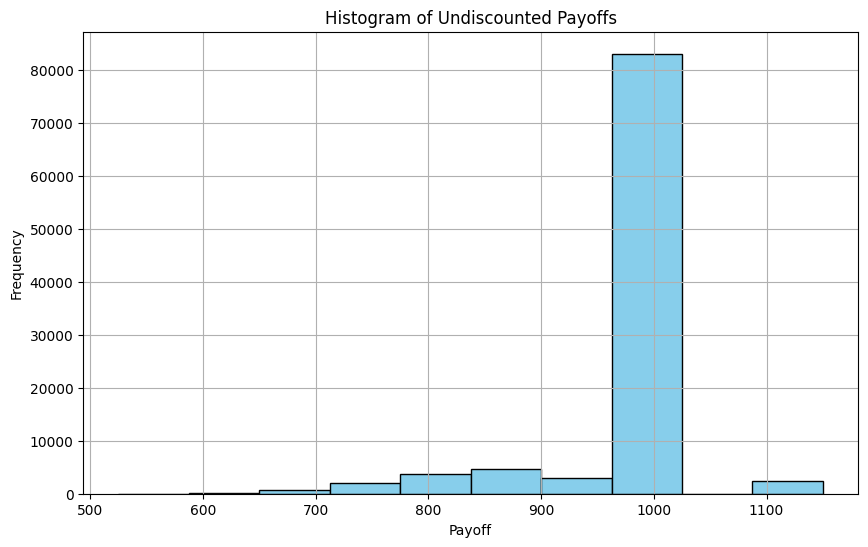

In [5]:
undiscounted_payoffs = np.zeros(100_000)
for i in range(100_000):
    #Observation date 1 Check (observation date is index 104)
    if equity_prices[i, 104] >= BS and ESTR_rates[i, 104] >= Br:
        undiscounted_payoffs[i] = notional
        continue

    #Observation date 2 Check (observation date is index 231)
    elif equity_prices[i, 231] >= BS and ESTR_rates[i, 231] >= Br: 
        undiscounted_payoffs[i] = notional
        continue

    #Maturity Check (index is 281)
    elif equity_prices[i, 281] >= BS and ESTR_rates[i, 281] >= Br: 
        undiscounted_payoffs[i] = notional * 1.15
        continue
    else:
        undiscounted_payoffs[i] = min(equity_prices[i, 281] / S0, ESTR_rates[i, 281] / r0) * notional

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(undiscounted_payoffs, color='skyblue', edgecolor='black')
plt.title("Histogram of Undiscounted Payoffs")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In the valuation above, most financial data were provided, but realistically, they are not provided by the termsheet we have to source them ourselves so here is a brief example for the stock volatility

In [6]:
import yfinance as yf

start = datetime.datetime(2024,1,1)
end = datetime.datetime(2024,12,31)


sp500_data = yf.download('^GSPC', start=start, end=end)
print(sp500_data.head())
prices = sp500_data['Close'].values
returns = []
for i in range(1, len(prices)):
    previous_price = prices[i - 1]
    current_price = prices[i]
    daily_return = (current_price - previous_price) / previous_price
    returns.append(daily_return)

daily_std = np.std(returns)
annual_volatility = daily_std * np.sqrt(252)
print(f"\n{annual_volatility:.2f} Which means we have a volatility of 13% for the S&P500 in 2024")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2024-01-02  4742.830078  4754.330078  4722.669922  4745.200195  3743050000
2024-01-03  4704.810059  4729.290039  4699.709961  4725.069824  3950760000
2024-01-04  4688.680176  4726.779785  4687.529785  4697.419922  3715480000
2024-01-05  4697.240234  4721.490234  4682.109863  4690.569824  3844370000
2024-01-08  4763.540039  4764.540039  4699.819824  4703.700195  3742320000

0.13 Which means we have a volatility of 13%


Observation : On the undiscounted Payoff graph, we see an overwhelming amount of payoffs at 1 000, meaning most paths led to an early redemption. \
I believe that's because of the ESTR rates Hull White model under constant parameters. I have noticed after printing a few of my paths that rate at maturity > r0 100% of the time, which could not be a random phenomenon. \
And Indeed, I found that, the drift is converging toward theta / kappa, which, in our example, is 7.7%, high above our barrier for the rate. Which means our rates are always above the knockout barrier's threshold.